Import Necessary libraries and change directory

In [1]:
import cptac
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [5]:
os.chdir('/mnt/c/Users/alanx/OneDrive/Desktop/QBIO490/analysis_data/')

In [15]:
# Downloading and loading GBM Data from CPTAC
cptac.download('GBM')
gbm = cptac.Gbm()

clinical = gbm.get_clinical() # Clinical Data
mutation = gbm.get_somatic_mutation() # Genomic Data
rna = gbm.get_transcriptomics() # Transcriptomic Data
protein = gbm.get_proteomics() # Proteomic Data
protein.columns = protein.columns.get_level_values(0) # Fix protein data columns

In [16]:
# Only retaining cancerous tissues
cancer_mask = clinical.loc[:,"Sample_Tumor_Normal"] == "Tumor"
clinical_ca = clinical.loc[cancer_mask,:]
rna_ca = rna.loc[cancer_mask,:]
protein_ca = protein.loc[cancer_mask,:]

In [96]:
# Retaining only patients with tumor re-occurence info
vit_mask = clinical.loc[:,"tumor_reoccur_after_treatment"].notna()
clinical_ca_vit = clinical_ca.loc[vit_mask,:]
rna_ca_vit = rna_ca.loc[vit_mask,:]
protein_ca_vit = protein_ca.loc[vit_mask,:]

In [101]:
# Retaining patients with ALDOB protein expression & ATF4 RNA Expression
aldob = protein_ca_vit.loc[:,"ALDOB"].notna()
sum(aldob == False)

0

In [109]:
atf4 = rna_ca_vit.loc[:,"ATF4"].notna()
sum(atf4.loc[:,'ENSG00000128272.13'] == False)

0

In [151]:
# Constructing the data and target columns
data = rna_ca_vit.loc[:,'ATF4']
data = data.join(protein_ca_vit.loc[:,'ALDOB'])
data

,ENSG00000128272.13,ALDOB
Patient_ID,,
C3L-00104,1.534000e+06,0.448224
C3L-00674,1.514208e+06,0.729797
C3L-01040,1.049490e+06,-0.704124
C3L-01048,1.287048e+06,-0.665132
C3L-01061,1.685317e+06,0.329687
...,...,...
C3N-03070,1.540373e+06,0.342134
C3N-03088,1.115616e+06,-0.256082
C3N-03182,2.442597e+06,-0.468068


In [138]:
clinical_ca_vit.loc[:,'tumor_reoccur_after_treatment']

Patient_ID
C3L-00104    False
C3L-00674     True
C3L-01040    False
C3L-01048    False
C3L-01061    False
             ...  
C3N-03070    False
C3N-03088    False
C3N-03182     True
C3N-03186     True
C3N-03188     True
Name: tumor_reoccur_after_treatment, Length: 66, dtype: object

Text(0.5, 0, 'ML Method')

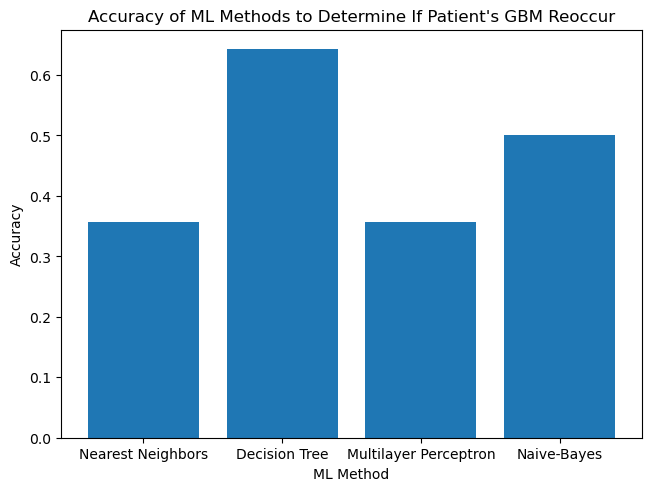

In [210]:
# Import necessary packages
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier # default number of neighbors looked at is 5
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

# Scaling the Data
scaler = StandardScaler()
data_x = scaler.fit_transform(data)

# Encoding the Result
encoder = OrdinalEncoder()
target = encoder.fit_transform(clinical_ca_vit.loc[:,'tumor_reoccur_after_treatment'].to_frame())

# set classifiers
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    MLPClassifier(),
    GaussianNB()
]

classifiers_names = ['Nearest Neighbors', 'Decision Tree', 'Multilayer Perceptron', 'Naive-Bayes']

X_train, X_test, y_train, y_test = train_test_split(data_x, target, train_size=0.8)

# Training; testing and plotting
result = []
for i in range(len(classifiers)):
    model = classifiers[i]
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    count = 0
    for j in range(len(y_pred)):
        if y_pred[j] == y_test[j]:
            count += 1
    result.append(count / len(y_test))
fig, axs = plt.subplots(1,1, constrained_layout=True)
axs.bar(classifiers_names,result)
axs.set_title("Accuracy of ML Methods to Determine If Patient's GBM Reoccur")
axs.set_ylabel("Accuracy")
axs.set_xlabel("ML Method")